In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [54]:
data = pd.read_csv('C:/Users/bydag/Downloads/train.csv')
sub = pd.read_csv('C:/Users/bydag/Downloads/sample_submission.csv')

In [4]:
print(data.head())
print(data.shape)

   user_id   order_completed_at  cart
0        2  2015-03-22 09:25:46   399
1        2  2015-03-22 09:25:46    14
2        2  2015-03-22 09:25:46   198
3        2  2015-03-22 09:25:46    88
4        2  2015-03-22 09:25:46   157
(3123064, 3)


## Создание датафрейма для работы

In [5]:
# Создаем столбец с номером заказа для кажого юзера
data_grouped = data.groupby(['user_id','order_completed_at'],as_index=False).sum()
data_grouped['order_number'] = data.groupby(['user_id','order_completed_at'],as_index=False).cumcount()
data = data.merge(data_grouped, on=['user_id','order_completed_at'],how='left')
data = data.drop('cart_y',axis=1)

Надо создать таргетную переменную, для каждого юзера, входят ли его товары в его последний заказ

In [6]:
# Для этого сначала создаем столбец, где True, если заказ пользователя последний
data['is_max_order_number'] = data.groupby('user_id')['order_number'].transform('max') == data['order_number']

In [7]:
# Создаем столбец, в котором для каждой строки отражается список категорий из последнего заказа пользователя
last_order = data[data['is_max_order_number'] == True]
last_order_grouped = last_order.groupby(['user_id', 'order_number'])['cart_x'].apply(list)

In [8]:
# Джойним к таблице столбец со списками категорий из последних заказов для каждого пользователя
data = data.merge(last_order_grouped, on=['user_id'],how='left')
data.head()

,user_id,order_completed_at,cart_x_x,order_number,is_max_order_number,cart_x_y
0,2,2015-03-22 09:25:46,399,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
1,2,2015-03-22 09:25:46,14,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
2,2,2015-03-22 09:25:46,198,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
3,2,2015-03-22 09:25:46,88,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
4,2,2015-03-22 09:25:46,157,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."


In [9]:
#Немного долго, создаем таргетную переменную (принимает значение 1, если категория есть в последнем заказе и ноль, если нет)
data['target'] = data.apply(lambda x: 1 if str(x['cart_x_x']) in str(x['cart_x_y']) else 0, axis=1)

In [10]:
#Оставляем только не последние заказы и дропаем лишние переменные
data_train = data[data['is_max_order_number']==False]
data_train = data_train.drop(['cart_x_y','is_max_order_number'],axis=1)
data_train.head()

,user_id,order_completed_at,cart_x_x,order_number,target
0,2,2015-03-22 09:25:46,399,12,0
1,2,2015-03-22 09:25:46,14,12,0
2,2,2015-03-22 09:25:46,198,12,0
3,2,2015-03-22 09:25:46,88,12,0
4,2,2015-03-22 09:25:46,157,12,0


In [11]:
# Проверяем размер датафрейма
data_train.shape

(2835076, 5)

In [12]:
# Для удобства переименуем переменную категории в ее изначальное название
data_train = data_train.rename(columns={'cart_x_x':'cart'})

## Feature engineering (создание объясняющих переменных)

Теперь из получившегося датасета мы можем создать таблицу, где для таргета будут созданы объясняющие переменные.
Например, можно сделать столбцы со следующей информацией,

относящейся к категориям:
- общее количество заказов с этой категорией,
- популярность категории (можно отранжировать все заказы по популярности и составить рейтинг)

относящейся к пользователям:
- общее количество заказов данного пользователя, 
- средний размер корзины пользователя (сколько всего категорий в заказе)

относящейся к паре пользователь-категория:
- бинарная переменная, является ли товар любимым у пользователя (1 - если да, 0 - нет)
- популярность категории у пользователя (количество заказов с этой категорией по отношению к числу всех его заказов)

In [13]:
#Общее количество заказов с каждой категорией 
total_orders_per_category = data_train.groupby('cart') \
.agg({'order_number':'nunique'}).rename(columns={'order_number':'total_orders_per_category'})

#Популярность категории
popularity = total_orders_per_category.sort_values(by='total_orders_per_category', ascending=False) \
.rank(ascending=False).astype(int) \
.rename(columns={'total_orders_per_category':'popularity'})

#Общее количество заказов каждого пользователя
total_orders_per_user = data_train.groupby('user_id') \
.agg({'order_number':'nunique'}) \
.rename(columns={'order_number':'total_orders_per_user'})

#Размер корзины пользователя
customer_basket_size = data_train \
.groupby(['user_id','order_number'],as_index=False).agg({'cart':'nunique'}) \
.groupby('user_id').agg({'cart':'mean'}) \
.rename(columns={'cart':'customer_basket_size'})

# Создаем переменную, которая хранит в себе самую часто покупаемую категорию для каждого пользователя
favorite = data_train.rename(columns={'cart':'favorite'}).groupby('user_id')['favorite'].apply(lambda x: x.value_counts().idxmax())

#Создаем переменную, которая хранит в себе количество заказов этой категории по отношнию ко всем его заказам
popularity_per_user = (data_train.groupby(['user_id','cart'])['order_number'] \
.count()/data_train.groupby(['user_id'])['order_number'].count()).reset_index() \
.rename(columns={'order_number':'popularity_per_user'})

Теперь присоединим столбцы к тренировочному датафрейму

In [14]:
data_train = data_train.merge(total_orders_per_category, on='cart',how='left')
data_train = data_train.merge(popularity, on='cart',how='left')
data_train = data_train.merge(total_orders_per_user, on='user_id',how='left')
data_train = data_train.merge(customer_basket_size, on='user_id',how='left')
data_train = data_train.merge(favorite, on='user_id',how='left')
data_train = data_train.merge(popularity_per_user, on=['user_id','cart'],how='left')

#После джойна также надо создать колонку, в которой будет 1, если категория является любмой и 0, если нет
data_train['favorite'] = np.where(data_train.cart==data_train.favorite,1,0)

In [15]:
data_train.head()

,user_id,order_completed_at,cart,order_number,target,total_orders_per_category,popularity,total_orders_per_user,customer_basket_size,favorite,popularity_per_user
0,2,2015-03-22 09:25:46,399,12,0,65,99,10,12.9,0,0.006711
1,2,2015-03-22 09:25:46,14,12,0,79,4,10,12.9,0,0.006711
2,2,2015-03-22 09:25:46,198,12,0,70,60,10,12.9,0,0.013423
3,2,2015-03-22 09:25:46,88,12,0,78,6,10,12.9,0,0.013423
4,2,2015-03-22 09:25:46,157,12,0,70,60,10,12.9,0,0.013423


Посмотрим на график корреляции между переменными. Как видим, популярность категории и общее количество заказов с этой категорией абсолютно скоррелированы (что очевидно, так как популярность рассчитывалась на основе второй). Для логит регрессии опустим переменную общего числа заказов с этой категорией. 

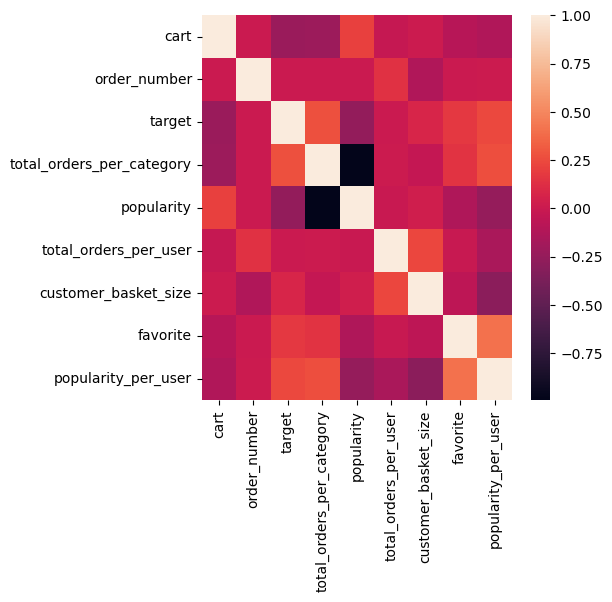

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

data = data_train.drop(['user_id','order_completed_at'],axis=1)
fig = plt.figure(figsize=(5, 5))
sns.heatmap(data.corr())

plt.show()

## Построение моделей

In [88]:
X = data_train.drop(['order_completed_at','target','popularity','user_id'],axis=1)
y = data_train.target

In [89]:
# Создадим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### Logistic Regression
Начнем с построения логистической регрессии с перебором параметров. По результам оценивания модели видим, что f-1 на тестовых данных равен 0,63

In [90]:
#так как логит чувствительна к масштабированию, отсандартизуем переменные
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
lrCV.fit(scal.fit_transform(X),y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1, param_grid={'C': (1e-05, 0.0001, 0.001, 0.01, 0.1)},
             scoring='f1')

In [91]:
predicted = lrCV.predict(scal.fit_transform(X_test))
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73    355183
           1       0.57      0.70      0.63    211833

    accuracy                           0.69    567016
   macro avg       0.68      0.69      0.68    567016
weighted avg       0.71      0.69      0.69    567016



In [62]:
lr = LogisticRegression(random_state=42, class_weight='balanced')
parameters = {'C': (0.00001, 0.0001, 0.001, 0.01, 0.1)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
lrCV = GridSearchCV(lr,param_grid=parameters,cv=skf,n_jobs=-1,scoring="f1")
lrCV.fit(X,y)

predicted = lrCV.predict(X_test)
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73    354736
           1       0.57      0.70      0.63    212280

    accuracy                           0.69    567016
   macro avg       0.68      0.69      0.68    567016
weighted avg       0.71      0.69      0.69    567016



In [80]:
pd.DataFrame({'name':X.columns,'coef':list(lrCV.best_estimator_.coef_.flatten())}).sort_values('coef',ascending=False)

,name,coef
6,popularity_per_user,29.401226
5,favorite,0.258567
4,customer_basket_size,0.037584
1,total_orders_per_category,0.021998
3,total_orders_per_user,0.000418
0,cart,-0.001786
2,popularity,-0.005265


### Bagging classifier
Теперь перейдем к ансамблевому методу. Результат он выдает хуже, чем для модели

In [64]:
bg = BaggingClassifier(lrCV.best_estimator_,max_features=4,n_estimators=100)
bg.fit(X,y)
predicted_bg = bg.predict(X_test)
print(classification_report(y_test,predicted_bg))

NameError: name 'bg2' is not defined

### Random Forest
Настройка параметров для леса выполняется слишком долго, поэтому попробуем построить на базовой модели. Результат на Kaggle вышел хуже, чем при использовании логистической регрессии (потому что здесь совсем не были измнены параметры).

In [36]:
# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
#                             class_weight='balanced')
# parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}
# rfCV = RandomizedSearchCV(rf,cv=skf,param_distributions=parameters,n_jobs=-1, scoring="f1",verbose=True)
# rfCV.fit(X,y)
# print(classification_report(y_test,predicted_bg))

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X,y)

C:\Users\bydag\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- target
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 8 features, but RandomForestClassifier is expecting 7 features as input.

In [39]:
predicted_rf = rf.predict(X_test)
print(classification_report(y_test,predicted_rf))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    354736
           1       0.94      0.97      0.95    212280

    accuracy                           0.96    567016
   macro avg       0.96      0.96      0.96    567016
weighted avg       0.96      0.96      0.96    567016



### CatBoost
Попробуем напоследок градиентный бустинг. Хотя на тестовых данных в ноутбуке дает результат, как у логистической регрессии, на Kaggle показывает себя намного хуже.

In [43]:
#! pip install catboost
from catboost import CatBoostClassifier

In [59]:
from catboost import Pool
params = {'verbose':200,'random_seed':42,'learning_rate':0.3}
model = CatBoostClassifier(**params)


X.drop('cart',axis=1)
X_test.drop('cart',axis=1) 



train_data = Pool(data=X,
                  label=y)

valid_data = Pool(data=X_test,
                  label=y_test)

model.fit(train_data,eval_set=valid_data)
predicted_cat = model.predict(X_test)
print(classification_report(y_test,predicted_cat))

0:	learn: 0.6158684	test: 0.6158658	best: 0.6158658 (0)	total: 535ms	remaining: 8m 54s
200:	learn: 0.4994135	test: 0.4994905	best: 0.4994905 (200)	total: 1m 47s	remaining: 7m 5s
400:	learn: 0.4876681	test: 0.4878088	best: 0.4878088 (400)	total: 3m 40s	remaining: 5m 29s
600:	learn: 0.4787679	test: 0.4788769	best: 0.4788769 (600)	total: 5m 45s	remaining: 3m 49s
800:	learn: 0.4712218	test: 0.4713773	best: 0.4713773 (800)	total: 7m 31s	remaining: 1m 52s
999:	learn: 0.4645902	test: 0.4646721	best: 0.4646721 (999)	total: 9m 18s	remaining: 0us

bestTest = 0.464672102
bestIteration = 999

              precision    recall  f1-score   support

           0       0.79      0.88      0.83    354736
           1       0.75      0.61      0.67    212280

    accuracy                           0.78    567016
   macro avg       0.77      0.74      0.75    567016
weighted avg       0.77      0.78      0.77    567016



### Light AutoML
Также попробуем (идея взята из ноутбука по Титанику: https://www.kaggle.com/code/alexryzhkov/lightautoml-titanic-love/notebook#Step-0.0.-Install-LightAutoML)

In [94]:
#!pip install lightautoml
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task


def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)
roles = {
    'target': 'target',
    'drop': ['order_completed_at','order_number','user_id'],
}


automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600,
                       cpu_limit = 4,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': 4})
oof_pred =  automl.fit_predict(data_train.drop('popularity',axis=1), roles=roles)

In [95]:
X_test['target'] = y_test
test_pred = automl.predict(X_test)
print('TEST score: {}'.format(f1_metric(X_test['target'].values, test_pred.data[:, 0])))

TEST score: 0.783522466519254


## Переходим к тестовому датасету

In [55]:
# Создаем отдельные колонки для user_id и категории
sub[['user_id', 'cart']] = sub['id'].str.split(';', expand=True).astype('int64')

# Подтягиваем все нужные дополнительные объясняющие переменные
sub = sub.merge(total_orders_per_category, on='cart',how='left')
sub = sub.merge(popularity, on='cart',how='left')
sub = sub.merge(total_orders_per_user, on='user_id',how='left')
sub = sub.merge(customer_basket_size, on='user_id',how='left')
sub = sub.merge(favorite, on='user_id',how='left')
sub = sub.merge(popularity_per_user, on=['user_id','cart'],how='left')
sub['favorite'] = np.where(sub.cart==sub.favorite,1,0)

# Дропаем ненужные колонки
user_id = sub['user_id']
sub = sub.drop(['target','id','user_id'],axis=1)

#В тестовом датафрейме есть категории, которых не было в тренировочном 
# (категории, которые были заказаны в последнем заказе), так что по этим категориям NA заполняем нулями
sub[sub.isna().any(axis=1)]
sub = sub.fillna(0)

#Предсказываем значения таргета для каждой пары пользователь-категория

sub['target'] = lrCV.predict(sub)
sub['user_id'] = user_id

# Снова создаем переменную пользователь-категория
sub['id'] = sub.user_id.astype(str)+';'+sub.cart.astype(str)

# Дропаем ненужные столбцы
sub.drop(['user_id','cart','total_orders_per_category','popularity','total_orders_per_user','customer_basket_size','favorite','popularity_per_user'],axis=1)

# Создаем нужный нам порядок переменных
sub = sub[['id','target']]

# Запсываем результат в csv файл
sub.to_csv('submission.csv', index = False)

Для Light AutoML делаем отдельно

In [ ]:
# Создаем отдельные колонки для user_id и категории
sub[['user_id', 'cart']] = sub['id'].str.split(';', expand=True).astype('int64')

# Подтягиваем все нужные дополнительные объясняющие переменные
sub = sub.merge(total_orders_per_category, on='cart',how='left')
#sub = sub.merge(popularity, on='cart',how='left')
sub = sub.merge(total_orders_per_user, on='user_id',how='left')
sub = sub.merge(customer_basket_size, on='user_id',how='left')
sub = sub.merge(favorite, on='user_id',how='left')
sub = sub.merge(popularity_per_user, on=['user_id','cart'],how='left')
sub['favorite'] = np.where(sub.cart==sub.favorite,1,0)

# Дропаем ненужные колонки
user_id = sub['user_id']
sub = sub.drop(['id','user_id'],axis=1)

#В тестовом датафрейме есть категории, которых не было в тренировочном 
# (категории, которые были заказаны в последнем заказе), так что по этим категориям NA заполняем нулями
sub[sub.isna().any(axis=1)]
sub = sub.fillna(0)

#Предсказываем значения таргета для каждой пары пользователь-категория

sub['target'] = (automl.predict(sub).data[:, 0]> 0.5).astype(int)
sub['user_id'] = user_id

# Снова создаем переменную пользователь-категория
sub['id'] = sub.user_id.astype(str)+';'+sub.cart.astype(str)

# Дропаем ненужные столбцы
sub.drop(['user_id','cart','total_orders_per_category','popularity','total_orders_per_user','customer_basket_size','favorite','popularity_per_user'],axis=1)

# Создаем нужный нам порядок переменных
sub = sub[['id','target']]

# Запсываем результат в csv файл
sub.to_csv('submission_automl.csv', index = False)

In [ ]:
sub.head()